In [1]:
# import libraries
import numpy as np                     
import seaborn as sns    
import pandas as pd               
import matplotlib.pyplot as plt                     
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split                   

In [3]:
# load the cow heart rate data
df = pd.read_csv('cow_heart_rate.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188089 entries, 0 to 188088
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        188089 non-null  object
 1   time_stamp  188089 non-null  object
 2   heart_rate  188089 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [6]:
# drop na in the dataframe
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188089 entries, 0 to 188088
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        188089 non-null  object
 1   time_stamp  188089 non-null  object
 2   heart_rate  188089 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [8]:
# clean data by removing zero heart reate
df_clean = df[df['heart_rate'] > 0]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183999 entries, 0 to 188088
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        183999 non-null  object
 1   time_stamp  183999 non-null  object
 2   heart_rate  183999 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.6+ MB


In [11]:
df_clean.shape[0] - df.shape[0]

-4090

<Axes: xlabel='Heart Rate', ylabel='Heart Rate Frequency'>

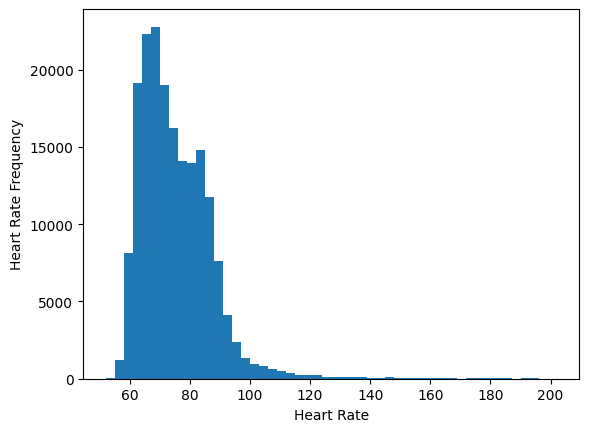

In [18]:
# visualize hr data
df_clean['heart_rate'].plot(kind='hist', 
                            bins=50,
                            xlabel=('Heart Rate'),
                            ylabel= ('Heart Rate Frequency'))

In [19]:
df_clean.head(3)

,date,time_stamp,heart_rate
0,7:57:03,0:02:21,99
1,7:57:04,0:02:22,100
2,7:57:05,0:02:23,101


In [21]:
# make the necessary data type conversion
df_clean['heart_rate'] = df_clean['heart_rate'].astype('int')
df_clean['date'] = pd.to_datetime(df_clean['date'])



C:\Users\Owner\AppData\Local\Temp\ipykernel_11212\3833967512.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['heart_rate'] = df_clean['heart_rate'].astype('int')
C:\Users\Owner\AppData\Local\Temp\ipykernel_11212\3833967512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['date'] = pd.to_datetime(df_clean['date'])


In [26]:
# drop specific column to clean the data
df_drop = df_clean.drop(columns=['time_stamp'], axis=1)
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183999 entries, 0 to 188088
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        183999 non-null  datetime64[ns]
 1   heart_rate  183999 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.2 MB


In [33]:
# x = df_drop.select_dtypes(include='datetime64[ns]').columns
# xx = df_drop[x[0]]
# print(xx)

In [30]:
def time_conversion(input_data):
    selected_column = input_data.select_dtypes(include='datetime64[ns]').columns
    column = input_data[selected_column[0]]
    
    input_data['hour'] = column.dt.hour
    input_data['minute'] = column.dt.minute
    input_data['second'] = column.dt.second
    
    return input_data


df_new = time_conversion(df_drop)  

In [34]:
df_new.head()

,date,heart_rate,hour,minute,second
0,2025-05-22 07:57:03,99,7,57,3
1,2025-05-22 07:57:04,100,7,57,4
2,2025-05-22 07:57:05,101,7,57,5
3,2025-05-22 07:57:06,102,7,57,6
4,2025-05-22 07:57:07,101,7,57,7


In [36]:
df_new.columns

Index(['date', 'heart_rate', 'hour', 'minute', 'second'], dtype='object')

In [55]:
# build rnn model
scaler = MinMaxScaler()

selected_data = df_new[[
                  'heart_rate', 
                  'hour', 
                  'minute', 
                  'second'       
]]

scaled_features = scaler.fit_transform(selected_data)
print(type(scaled_features))

# create your x and y variables
sequence = 3
X, y = [], []

target_col = 0

for index in range(len(selected_data) - sequence):
    X.append(scaled_features[index:index+sequence])
    y.append(scaled_features[index+sequence, target_col])
    
X = np.array(X)
y = np.array(y)

# print 
print(y)


<class 'numpy.ndarray'>
[0.33333333 0.32666667 0.32       ... 0.08       0.08       0.08666667]


In [61]:
# Create deep learning model

from tensorflow.keras.models import Sequential    
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# train test split      
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

# create the model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(1)) 

# compile the model
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# fit the model
# early stopping)
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

history = model.fit(X_train, y_train,
                    epochs =100,
                    batch_size =32,
                    validation_data = (X_test,y_test),
                    callbacks = [early_stopping],
                    verbose = 1
                    )


(147196, 3, 4)
(147196,)


c:\Users\Owner\juggle_ds\juggle_ds\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 7.4544e-04 - mean_squared_error: 7.4544e-04 - val_loss: 8.6402e-05 - val_mean_squared_error: 8.6402e-05
Epoch 2/100
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - loss: 1.5021e-04 - mean_squared_error: 1.5021e-04 - val_loss: 2.2565e-04 - val_mean_squared_error: 2.2565e-04
Epoch 3/100
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 1.4395e-04 - mean_squared_error: 1.4395e-04 - val_loss: 3.6999e-05 - val_mean_squared_error: 3.6999e-05
Epoch 4/100
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 1.1322e-04 - mean_squared_error: 1.1322e-04 - val_loss: 2.8685e-05 - val_mean_squared_error: 2.8685e-05
Epoch 5/100
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 101s 13ms/step - loss: 9.7461e-05 - mean_squared_error: 9.7461e-05 - val_loss: 2.6593e-05 - val_mean_squared_error: 2.6593e-05
Epoch 6/100
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - loss: 9.9376e-05 - mean_squared_error: 9.9376e-05 - val_loss: 2.5838e-05 - val_mean_squared_error:

In [65]:
model.history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

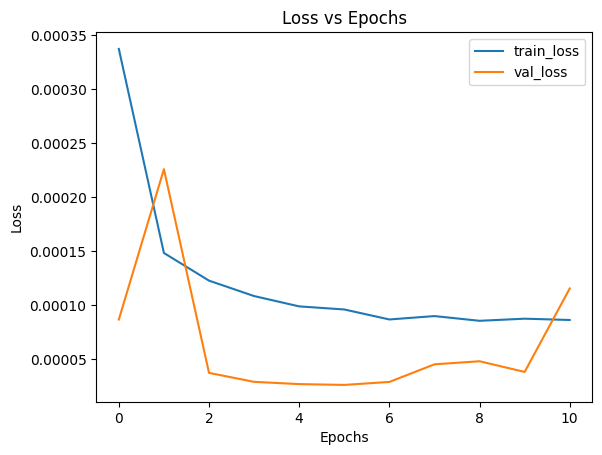

In [70]:
loss_df = pd.DataFrame(model.history.history)
loss_df.head()

# plot loss against epochs
plt.plot(loss_df['loss'], label='train_loss')
plt.plot(loss_df['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

In [86]:
# make y predictions of heart rate
y_pred = model.predict(X_test)

1150/1150 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


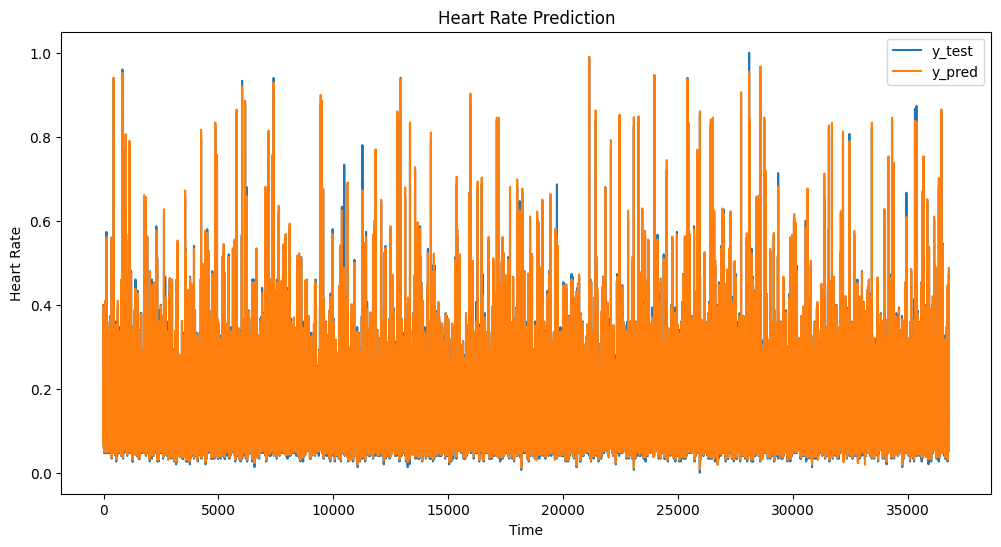

In [ ]:
# create a plot of the y_test and y_pred unscalled
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Prediction')
plt.legend()
plt.show()

(36800,)
(36800,)


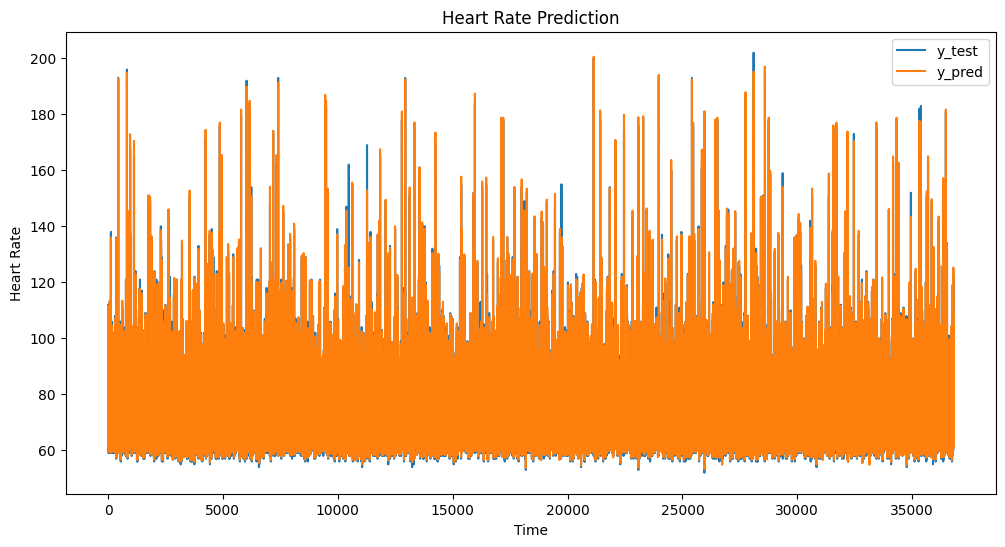

In [88]:
# # Inverse scale to get actual minutes
col_means = scaled_features.mean(axis=0)

def invert_scale(y_scaled, scaler, feature_index=0):
    dummy = np.tile(col_means, (len(y_scaled), 1))  # Fill dummy with average values
    dummy[:, feature_index] = y_scaled.ravel()
    return scaler.inverse_transform(dummy)[:, feature_index]

# invese scale the y_pred and y_test
y_pred_hr = invert_scale(y_pred, scaler)
y_test_hr = invert_scale(y_test, scaler)

print(y_pred_hr.shape)
print(y_test_hr.shape)

# create a plot of the y_test and y_pred
plt.figure(figsize=(12, 6))
plt.plot(y_test_hr, label='y_test')
plt.plot(y_pred_hr, label='y_pred')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Prediction')
plt.legend()
plt.show()

MAE: 0.44 bpm, MSE: 0.58 bpm)


C:\Users\Owner\AppData\Local\Temp\ipykernel_11212\3734053575.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


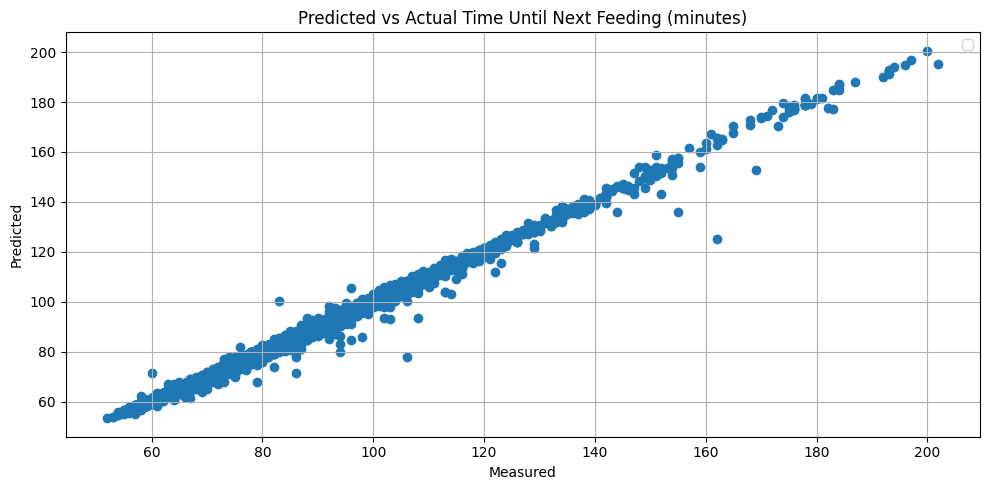

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_hr, y_pred_hr)
mse = mean_squared_error(y_test_hr, y_pred_hr)
print(f"MAE: {mae:.2f} bpm, MSE: {mse:.2f} bpm)")

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(y_test_hr,y_pred_hr)

# plt.plot(y_pred_minutes[:100], label='Predicted', marker='x')
plt.title('Predicted vs Actual Time Until Next Feeding (minutes)')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
npdata = np.arange(1,10,1)
npdata[0:4]

array([1, 2, 3, 4])

In [43]:
mylist = [1,2,3,4,5]
print(len(mylist))
seq = 2

xa, ya = [],[]
for i in range(len(mylist) - seq):
    xa.append(mylist[i:i+seq])
    ya.append(mylist[i+seq])
    
    # print(i)
print(xa)
print(ya)

5
[[1, 2], [2, 3], [3, 4]]
[3, 4, 5]
